[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/phandai/food101-inference)

# Preparation

In [1]:
import pandas as pd
import numpy as np
import os 
import torch
import random
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import timm
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score,classification_report
import torchvision.transforms as T

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Config 

In [2]:
print("This is inference result for version", 5)
print("Please check `WEIGHT_DIR`, `resize_width`, `resize_height`")
print("Please make sure the augmentation is correct")

This is inference result for version 5
Please check `WEIGHT_DIR`, `resize_width`, `resize_height`
Please make sure the augmentation is correct


In [3]:
IMAGE_BASE_DIR = "/kaggle/input/food41/images"
META_BASE_DIR = "/kaggle/input/food41/meta/meta"
WEIGHT_DIR = "/kaggle/input/food101-resnet50-v3-weight/weight" # this is version 5
SAVE_OUTPUT_DIR = "/kaggle/working/output" 

In [4]:
num_epochs = 15
num_workers, batch_size = 4, 64
resized_width = 224
resized_height = 224
verbose = 0

In [5]:
model_name = 'resnet50'

# Train and test df

In [6]:
# Load json for train and test
with open(f"{META_BASE_DIR}/train.json", 'r') as file:
    train_json = json.load(file)
with open(f"{META_BASE_DIR}/test.json", 'r') as file:
    test_json = json.load(file)

In [7]:
# Now, let convert those json format to dataframe
def json_to_dataframe(data_json):
    data_rows = []
    for label, image_paths in data_json.items():
        for image_path in image_paths:
            data_rows.append([label, image_path])
    df = pd.DataFrame(data_rows, columns=['label', 'image_path'])
    df['filepath'] = IMAGE_BASE_DIR+'/' + df['image_path'] +'.jpg'
    return df

In [8]:
df_train = json_to_dataframe(train_json)
df_test = json_to_dataframe(test_json)

In [9]:
print(df_train.columns)
print(df_test.columns)

Index(['label', 'image_path', 'filepath'], dtype='object')
Index(['label', 'image_path', 'filepath'], dtype='object')


In [10]:
num_classes = df_train['label'].nunique()

# Dataset

In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])
df_train['num_label'] = label_encoder.transform(df_train['label'])
df_test['num_label'] = label_encoder.transform(df_test['label'])

In [12]:
class FoodDataset(Dataset):
    def __init__(self, df, transforms=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with 'filepath' and 'label' columns.
            transforms (albumentations.Compose): Augmentation pipeline.
            label_encoder (LabelEncoder): Fitted label encoder. If None, a new one will be created.
        """
        self.df = df
        self.transforms = transforms
        
        # Convert string labels to numeric IDs
        self.numeric_labels = df['num_label']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        img_path = record['filepath']
        
        # Verify if the image path exists
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file {img_path} does not exist.")

        # Load and convert image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Apply transforms if any
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        # Get numeric label
        label = self.numeric_labels[idx]
        return image, label

# Augmentation

Essential Augmentation Techniques
1. Horizontal and Vertical Flips
2. Random Rotations
3. Random Cropping and Resizing
4. Color Jitter (Brightness, Contrast, Saturation, Hue)
5. Scaling and Zooming
6. Random Shear and Affine Transformations
7. Random Grayscale Conversion
8. Normalization

In [13]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose([
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10),
            ], p=0.7),
            A.OneOf([
                A.GaussianBlur(blur_limit=3),
                A.GaussNoise(var_limit=(5.0, 30.0)),
            ], p=0.5),
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.5),  # Reduced distort_limit
                A.GridDistortion(num_steps=5, distort_limit=0.5), # Reduced distort_limit
            ], p=0.3), # Reduced probability
            A.Resize(resized_height, resized_width),
            A.CoarseDropout(
                max_height=int(resized_height * 0.125),  # 5% of height
                max_width=int(resized_width * 0.125),    # 5% of width
                min_holes=5,                            # Minimum number of dropouts
                max_holes=8,                           # Maximum number of dropouts
                fill_value=0,                           # Fill with black
                mask_fill_value=None,
                p=0.7
            ),
            A.Resize(height=resized_height, width=resized_width),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], p=1.0) # Overall probability of applying the transform
    else:
        return A.Compose([
            A.Resize(height=resized_height, width=resized_width),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
            ToTensorV2()
        ])

## Visualize transformed images

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


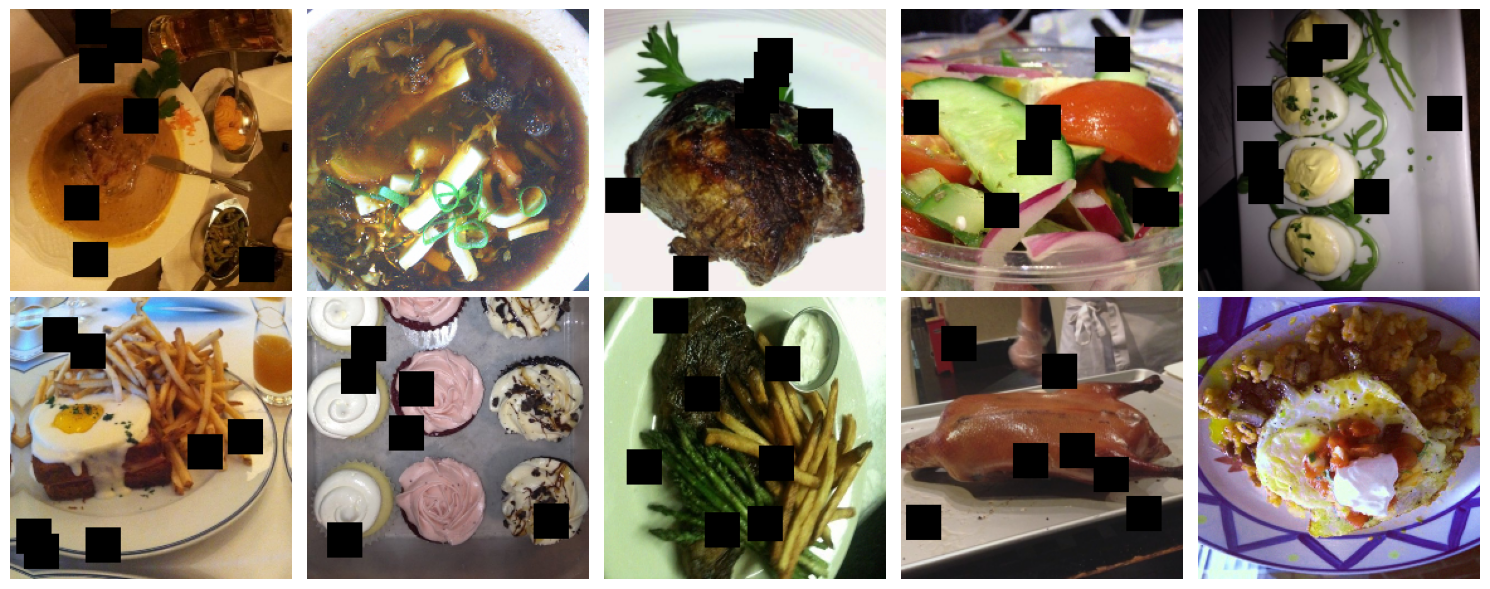

In [14]:
train_dataset = FoodDataset(df_train, transforms=get_transforms(mode="train"))

# Function to display images
def visualize_augmentations(dataset, num_samples=10, cols=5):
    """
    Visualizes augmented images from the dataset.

    Args:
        dataset (Dataset): The dataset to visualize.
        num_samples (int): Number of samples to visualize.
        cols (int): Number of columns in the grid.
    """
    dataset_copy = copy.deepcopy(dataset)
    transforms = dataset_copy.transforms.transforms
    transforms_filtered = [t for t in transforms if not isinstance(t, (A.Normalize, ToTensorV2))]
    dataset_copy.transforms = A.Compose(transforms_filtered)
    
    rows = num_samples // cols + int(num_samples % cols > 0)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 3, rows * 3))
    ax = ax.flatten() if num_samples > 1 else [ax]
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset_copy))
        image, _ = dataset_copy[idx]  # Ignore the label
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
            image = np.clip(image, 0, 1)
        else:
            image = image.astype(np.uint8)
        ax[i].imshow(image)
        ax[i].axis('off')
    for j in range(num_samples, len(ax)):
        ax[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some augmented images
visualize_augmentations(train_dataset, num_samples=10, cols=5)

# KFold and train-val splits

In [15]:
n_splits = 5
skf = StratifiedKFold(n_splits, shuffle=True, random_state=42)
# Select fold 0
fold = 0
def get_train_val_from_fold(fold,val=False):
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X=df_train, y=df_train['label'])):
        if fold_idx == fold:
            print(f"Selected Fold: {fold}")
            train_df = df_train.iloc[train_idx].reset_index(drop=True)
            val_df = df_train.iloc[val_idx].reset_index(drop=True)
            if val: return train_df, val_df, val_idx
            return train_df, val_df
            

# Dataloader

In [16]:
def get_loader_from_fold(fold, num_workers, batch_size,val=False):
    if val: train_df, val_df, val_idx = get_train_val_from_fold(fold,val=True)
    else: train_df, val_df = get_train_val_from_fold(fold)
    train_dataset = FoodDataset(
        df=train_df, 
        transforms=get_transforms(mode="train")
    )
    val_dataset = FoodDataset(
        df=val_df, 
        transforms=get_transforms(mode="val")
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    if val: return train_loader,val_loader, val_idx 
    return train_loader,val_loader

# Model 

In [17]:
# --- Set Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
def load_model(model_name,device=device):
    model = timm.create_model(model_name, num_classes=num_classes, pretrained=True)
    return model.to(device)

# Visualize results

In [19]:
def load_from_checkpoint(checkpoint_path, model_name, device='cuda',print_info=True):
    """
    Load model and training state from a checkpoint.
    
    Args:
        checkpoint_path (str): Path to the checkpoint file
        model (nn.Module): Model architecture to load weights into
        device (str): Device to load the model onto
        
    Returns:
        model: Loaded model
        checkpoint: Complete checkpoint dictionary
    """
    model = load_model(model_name)
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=True)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    if print_info:
        # Print checkpoint info
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        print(f"Training metrics at checkpoint:")
        print(f"Train Loss: {checkpoint['train_loss']:.4f}")
        print(f"Val Loss: {checkpoint['val_loss']:.4f}")
        print(f"Train Acc: {checkpoint['train_acc']:.4f}")
        print(f"Val Acc: {checkpoint['val_acc']:.4f}")
    
    return model, checkpoint['history']

In [20]:
def plot_training_history(history):
    """
    Plot training metrics history.
    
    Args:
        history (dict): Dictionary containing training metrics history
    """
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rate
    ax3.plot(history['learning_rates'], label='Learning Rate')
    ax3.set_title('Learning Rate History')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.legend()
    ax3.grid(True)
    ax3.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Loaded checkpoint from epoch 10
Training metrics at checkpoint:
Train Loss: 0.3384
Val Loss: 0.8401
Train Acc: 0.8999
Val Acc: 0.7956


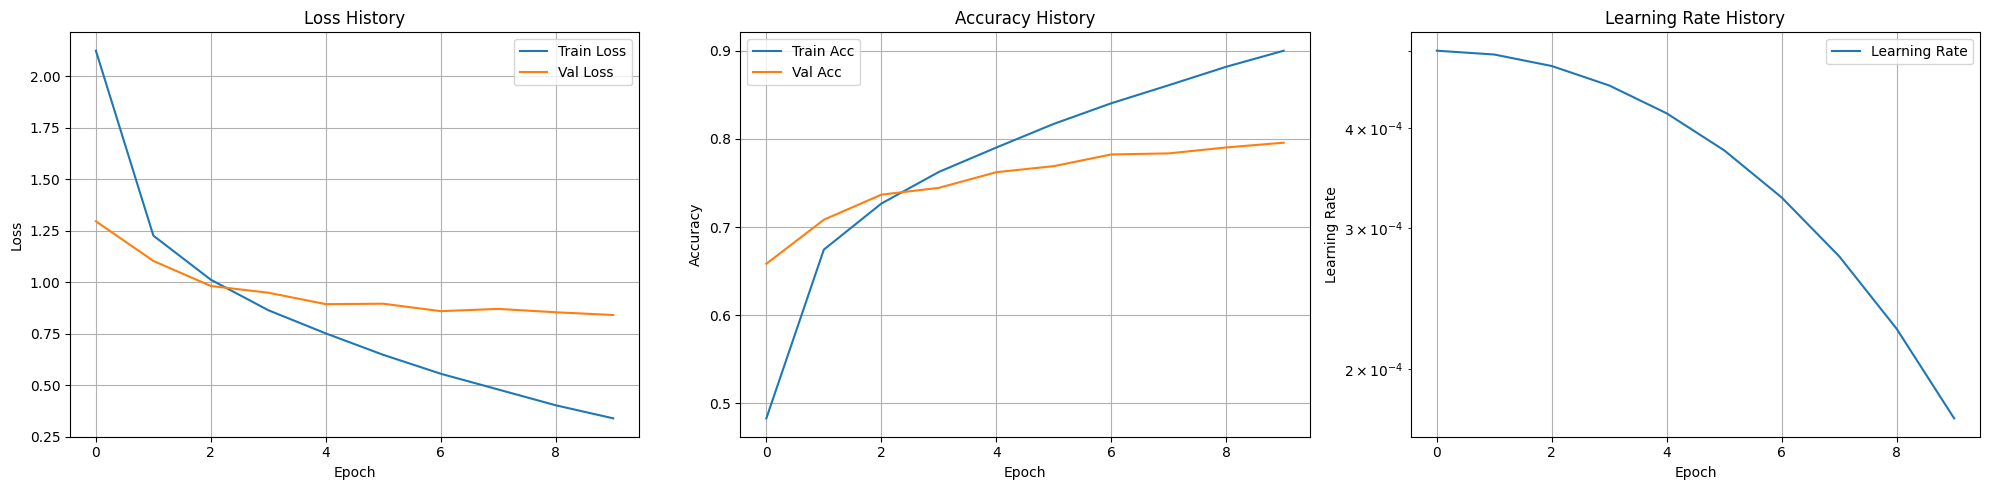

Loaded checkpoint from epoch 14
Training metrics at checkpoint:
Train Loss: 0.1992
Val Loss: 0.8352
Train Acc: 0.9433
Val Acc: 0.8030


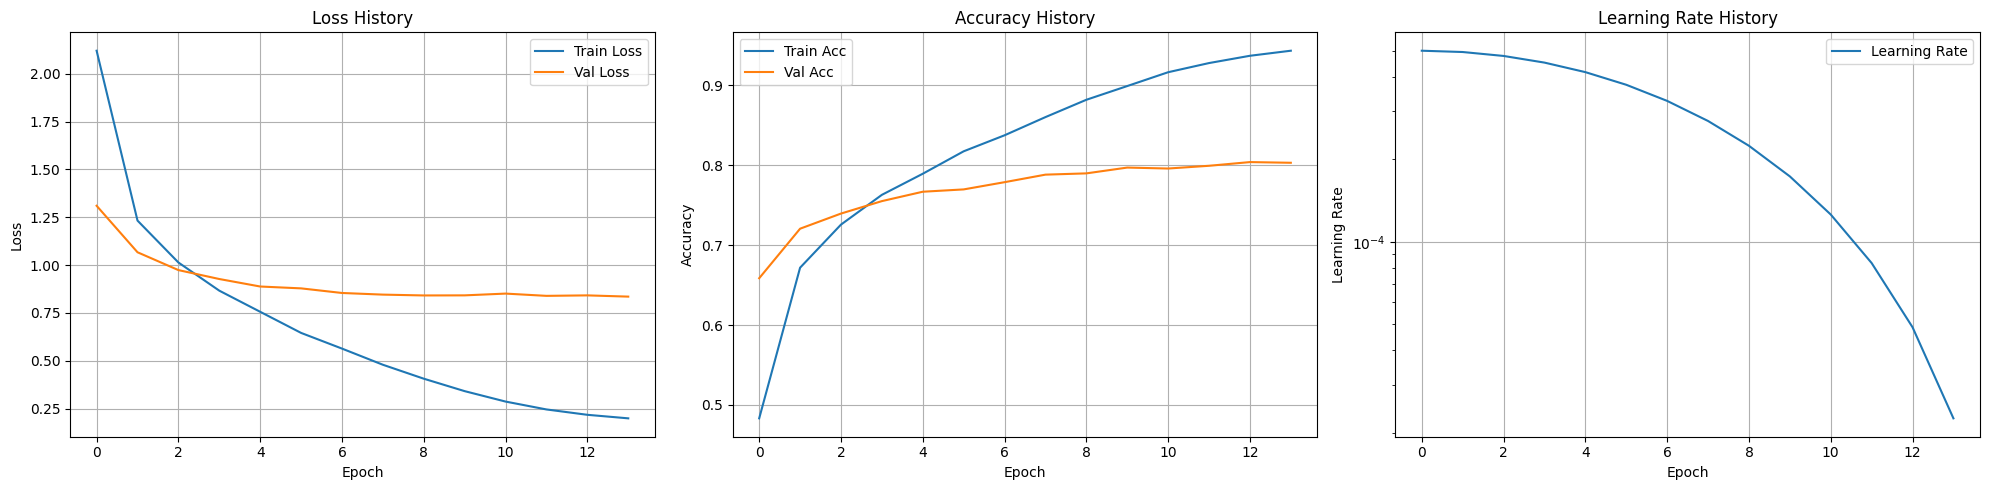

Loaded checkpoint from epoch 15
Training metrics at checkpoint:
Train Loss: 0.1887
Val Loss: 0.8410
Train Acc: 0.9464
Val Acc: 0.8079


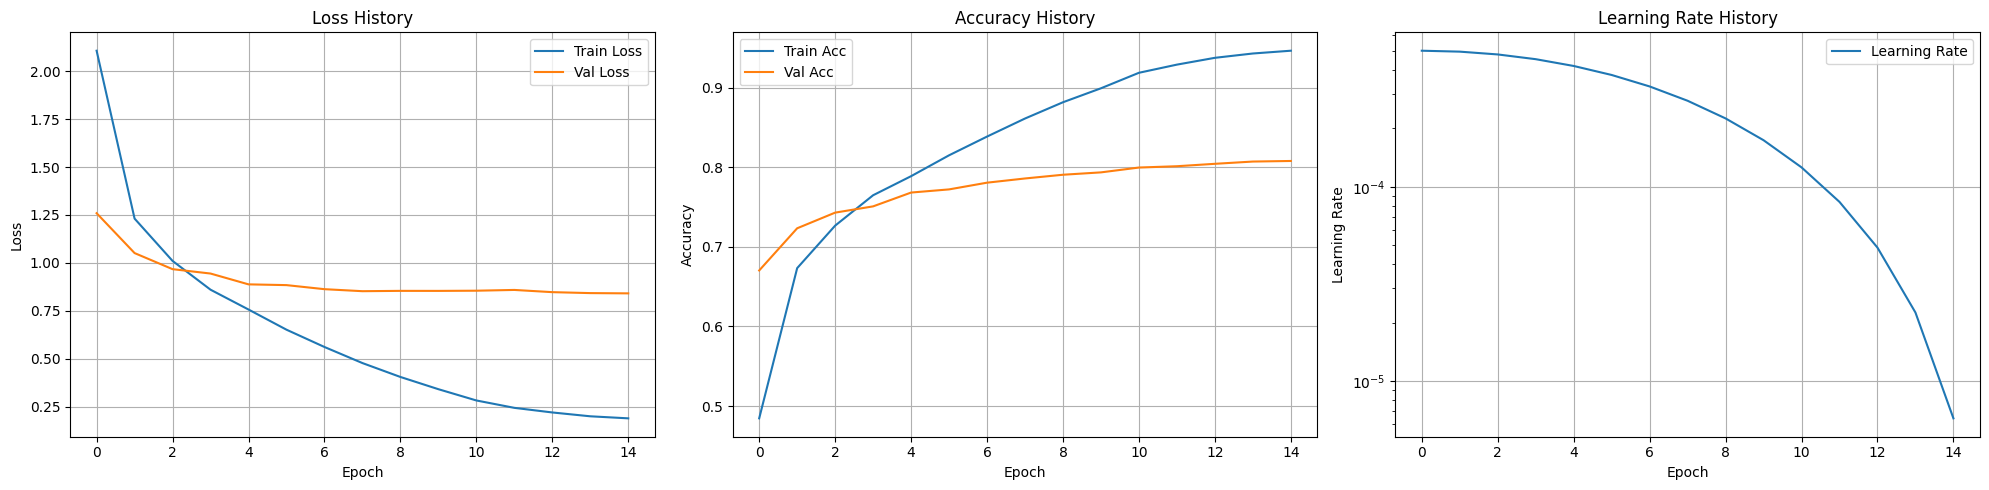

Loaded checkpoint from epoch 15
Training metrics at checkpoint:
Train Loss: 0.1895
Val Loss: 0.8357
Train Acc: 0.9462
Val Acc: 0.8007


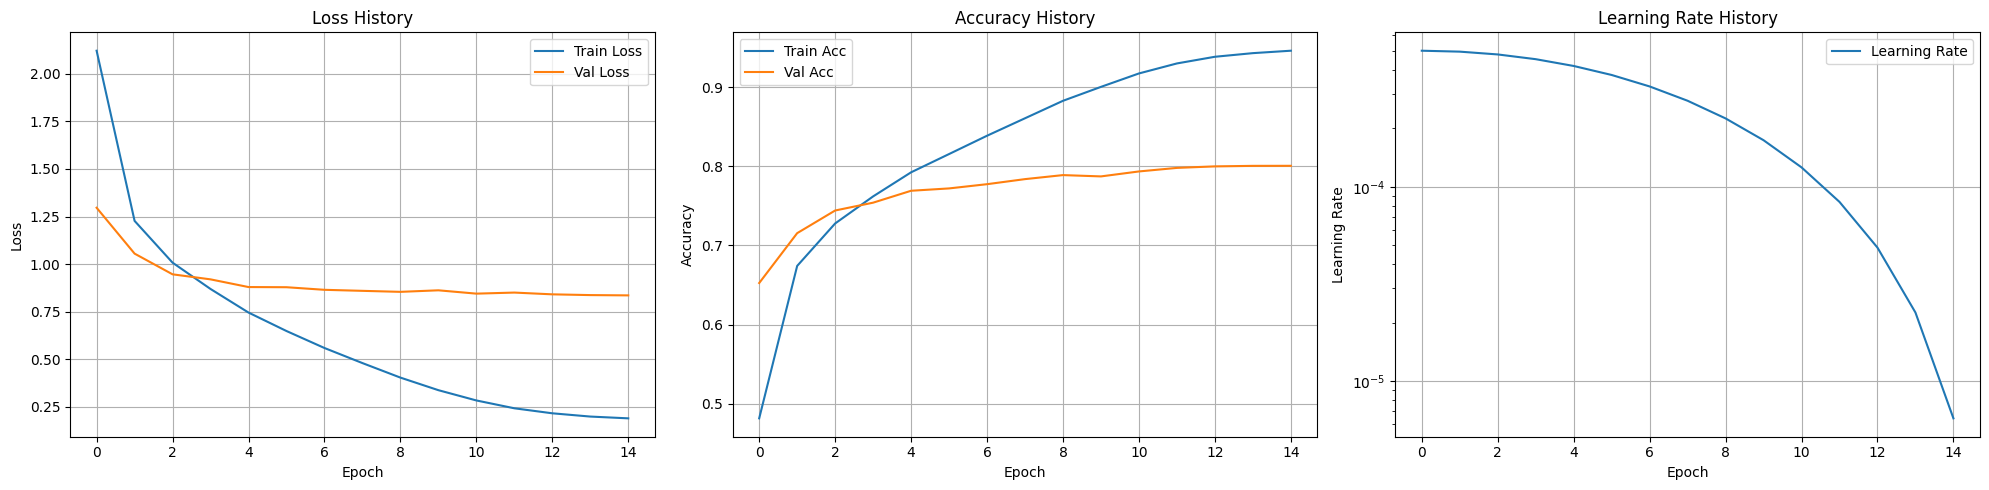

Loaded checkpoint from epoch 15
Training metrics at checkpoint:
Train Loss: 0.1872
Val Loss: 0.8605
Train Acc: 0.9467
Val Acc: 0.8033


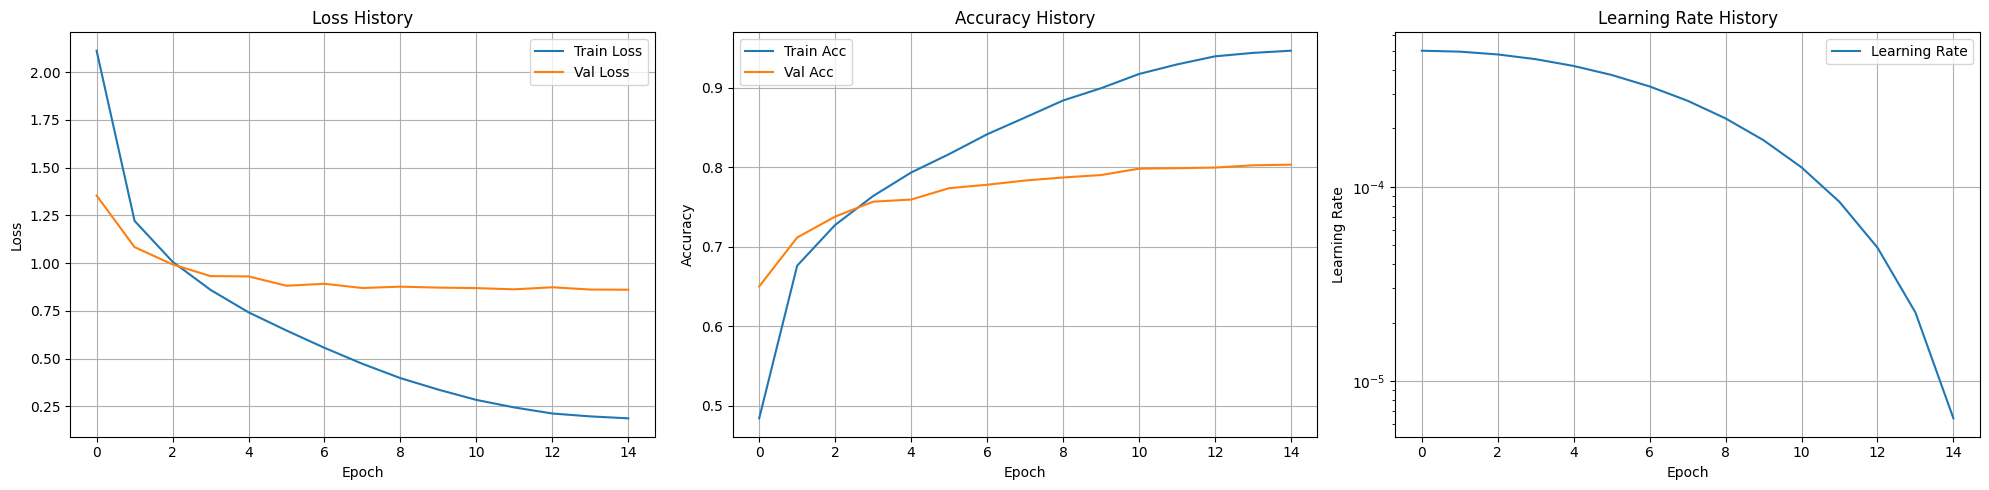

In [21]:
for num_fold in range(n_splits):
    _, history = load_from_checkpoint(f"{WEIGHT_DIR}/{model_name}_fold_{num_fold}.pth",model_name,device=device)
    plot_training_history(history)

# Evaluate on Validation set

In [22]:
def val_evaluate(model, fold, val_loader, device,verbose=1):
    model.eval()
    preds = []
    with torch.no_grad():
        if verbose == 1:
            progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
        else: progress_bar = enumerate(val_loader)
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            preds.append(torch.softmax(outputs,dim=1))
    preds = torch.vstack(preds)
    return preds

In [23]:
preds_list = []
idx_list = []
for num_fold in range(n_splits):
    model, _ = load_from_checkpoint(f"{WEIGHT_DIR}/{model_name}_fold_{num_fold}.pth",model_name,device=device, print_info=0)
    train_loader,val_loader, val_idx = get_loader_from_fold(num_fold, num_workers, batch_size,val=True)
    preds = val_evaluate(model,num_fold, val_loader,device)
    preds_list.append(preds)
    idx_list.extend(val_idx)

Selected Fold: 0


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
100%|██████████| 237/237 [00:54<00:00,  4.33it/s]


Selected Fold: 1


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
100%|██████████| 237/237 [00:52<00:00,  4.52it/s]


Selected Fold: 2


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
100%|██████████| 237/237 [00:52<00:00,  4.52it/s]


Selected Fold: 3


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
100%|██████████| 237/237 [00:54<00:00,  4.36it/s]


Selected Fold: 4


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
100%|██████████| 237/237 [00:53<00:00,  4.44it/s]


In [24]:
preds_list = torch.concat(preds_list,dim=0)

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import torch

def save_soft_predictions_to_val_df(predictions, idx, label_encoder, pred_df_path=None):
    """
    Optimized function to convert model soft predictions to a DataFrame with one column per class,
    handling out-of-order indices, and optionally saving it to a CSV file.

    Args:
        predictions (np.ndarray or torch.Tensor): Model predictions of shape (N, D),
                                                 where N is the number of samples
                                                 and D is the number of classes.
        idx (np.ndarray or list): Array or list of indices corresponding to the
                                  predictions. These indices are not necessarily
                                  in order.
        label_encoder (LabelEncoder): The LabelEncoder used to encode class labels.
        pred_df_path (str, optional): Path to save the DataFrame as a CSV file.
                                      If None, the DataFrame is not saved.
                                      Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame with sample IDs and predicted probabilities
                      for each class, with rows ordered according to the
                      original sample order.
    """
    # Convert predictions to NumPy array if it's a torch.Tensor
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().detach().numpy()

    # Get class labels from the LabelEncoder
    class_labels = label_encoder.classes_

    # Create a DataFrame from predictions with 'sample_id' as the index
    pred_df = pd.DataFrame(predictions, index=idx, columns=class_labels)

    # Determine the total number of samples based on the maximum index
    num_samples = max(idx) + 1

    # Reindex the DataFrame to include all sample IDs, filling missing entries with zeros
    # You can change fill_value=0 to another value if appropriate
    pred_df = pred_df.reindex(range(num_samples), fill_value=0)

    # Reset the index to have 'sample_id' as a column
    pred_df.reset_index(inplace=True)
    pred_df.rename(columns={'index': 'sample_id'}, inplace=True)

    # Optional: Ensure 'sample_id' is the first column
    cols = ['sample_id'] + [col for col in pred_df.columns if col != 'sample_id']
    pred_df = pred_df[cols]

    # Save to CSV if a path is provided
    if pred_df_path:
        directory = os.path.dirname(pred_df_path)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
        pred_df.to_csv(pred_df_path, index=False)
        print(f"Predictions saved to {pred_df_path}")

    return pred_df

In [26]:
pred_df = save_soft_predictions_to_val_df(preds_list,idx_list,label_encoder,f"{SAVE_OUTPUT_DIR}/oof_{model_name}.csv")
preds = np.argmax(pred_df.values[:,1:],axis=1)

Created directory: /kaggle/working/output
Predictions saved to /kaggle/working/output/oof_resnet50.csv


In [27]:
def evaluate(truth,preds,name):
    print(f"{name} accuracy:", accuracy_score(truth,preds))
    print(f"{name} report:")
    print(classification_report(truth,preds,zero_division=0))

In [28]:
evaluate(df_train.num_label,preds,"VAL")

VAL accuracy: 0.8021122112211221
VAL report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       750
           1       0.81      0.80      0.81       750
           2       0.86      0.84      0.85       750
           3       0.85      0.83      0.84       750
           4       0.70      0.73      0.72       750
           5       0.73      0.73      0.73       750
           6       0.84      0.85      0.85       750
           7       0.91      0.91      0.91       750
           8       0.63      0.62      0.63       750
           9       0.78      0.78      0.78       750
          10       0.74      0.73      0.74       750
          11       0.84      0.86      0.85       750
          12       0.89      0.86      0.88       750
          13       0.83      0.83      0.83       750
          14       0.79      0.76      0.77       750
          15       0.70      0.68      0.69       750
          16       0.83      0.86   

# Evaluate on Test set

In [29]:
test_dataset = FoodDataset(
        df=df_test, 
        transforms=get_transforms(mode="test")
    )
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers
)

In [30]:
def save_soft_predictions_to_dataframe(predictions, label_encoder, pred_df_path=None):
    """
    Converts model soft predictions to a DataFrame with one column per class 
    and optionally saves it to a CSV file.

    Args:
        predictions (np.ndarray or torch.Tensor): Model predictions of shape (N, D), 
                                                 where N is the number of samples 
                                                 and D is the number of classes.
        label_encoder (LabelEncoder): The LabelEncoder used to encode class labels.
        pred_df_path (str, optional): Path to save the DataFrame as a CSV file. 
                                      If None, the DataFrame is not saved.
                                      Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame with sample IDs and predicted probabilities 
                      for each class.
    """

    # If predictions is a torch.Tensor, convert it to a NumPy array
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().detach().numpy()
    
    # Get the class labels from the LabelEncoder
    class_labels = label_encoder.classes_
    # Create a DataFrame with one column per class
    pred_df = pd.DataFrame(predictions, columns=class_labels)
    
    # Add a sample_id column
    pred_df.insert(0, 'sample_id', range(len(pred_df)))
    
    # Save to CSV if a path is provided
    if pred_df_path:
        pred_df.to_csv(pred_df_path, index=False)
        print(f"Predictions saved to {pred_df_path}")
    
    return pred_df

## TTA 8

In [31]:
# Define TTA transforms using functional operations
tta_transforms = [
    lambda x: x,  # Original
    lambda x: T.functional.hflip(x),  # Horizontal flip
    lambda x: T.functional.vflip(x),  # Vertical flip
    lambda x: T.functional.vflip(T.functional.hflip(x)),  # Both flips
    lambda x: T.functional.rotate(x, 90),  # 90 degrees
    lambda x: T.functional.rotate(x, 180),  # 180 degrees
    lambda x: T.functional.rotate(x, 270),  # 270 degrees
    lambda x: T.functional.rotate(T.functional.hflip(x), 90)  # Horizontal flip + 90 degrees
]

def test_evaluate_tta8(model, fold, test_loader, device, verbose=1):
    model.eval()
    preds = []
    with torch.no_grad():
        if verbose == 1:
            progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        else:
            progress_bar = enumerate(test_loader)
            
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)
            
            # Apply TTA and get predictions
            batch_preds = []
            for transform in tta_transforms:
                augmented_data = transform(data)
                outputs = model(augmented_data)
                batch_preds.append(torch.softmax(outputs, dim=1))
                
            # Average predictions from all augmentations
            avg_preds = torch.stack(batch_preds).mean(dim=0)
            preds.append(avg_preds)
            
    preds = torch.vstack(preds)
    return preds

In [32]:
preds = 0
preds_list = []
for num_fold in range(n_splits):
    model, _ = load_from_checkpoint(f"{WEIGHT_DIR}/{model_name}_fold_{num_fold}.pth",model_name,device=device, print_info=0)
    preds =test_evaluate_tta8(model,num_fold, test_loader,device)
    save_soft_predictions_to_dataframe(preds,label_encoder,f"{SAVE_OUTPUT_DIR}/test_{model_name}_fold_{num_fold}.csv")
    preds_list.append(preds)
    preds = np.argmax(preds.cpu().detach().numpy(),axis=1)
    evaluate(df_test.num_label,preds,f"Test {num_fold+1}")

100%|██████████| 395/395 [04:50<00:00,  1.36it/s]


Predictions saved to /kaggle/working/output/test_resnet50_fold_0.csv
Test 1 accuracy: 0.8558019801980198
Test 1 report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       250
           1       0.84      0.85      0.85       250
           2       0.91      0.90      0.91       250
           3       0.88      0.92      0.90       250
           4       0.77      0.88      0.82       250
           5       0.81      0.76      0.78       250
           6       0.89      0.88      0.89       250
           7       0.93      0.94      0.93       250
           8       0.73      0.61      0.66       250
           9       0.88      0.78      0.83       250
          10       0.85      0.79      0.82       250
          11       0.89      0.90      0.90       250
          12       0.89      0.94      0.91       250
          13       0.79      0.90      0.84       250
          14       0.85      0.84      0.84       250
          15   

100%|██████████| 395/395 [04:49<00:00,  1.37it/s]


Predictions saved to /kaggle/working/output/test_resnet50_fold_1.csv
Test 2 accuracy: 0.8624554455445544
Test 2 report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       250
           1       0.88      0.87      0.88       250
           2       0.90      0.90      0.90       250
           3       0.93      0.90      0.91       250
           4       0.79      0.87      0.83       250
           5       0.82      0.78      0.80       250
           6       0.89      0.91      0.90       250
           7       0.97      0.95      0.96       250
           8       0.67      0.73      0.70       250
           9       0.83      0.80      0.81       250
          10       0.85      0.77      0.81       250
          11       0.86      0.92      0.89       250
          12       0.95      0.92      0.93       250
          13       0.83      0.88      0.85       250
          14       0.84      0.82      0.83       250
          15   

100%|██████████| 395/395 [04:49<00:00,  1.37it/s]


Predictions saved to /kaggle/working/output/test_resnet50_fold_2.csv
Test 3 accuracy: 0.8607128712871287
Test 3 report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       250
           1       0.90      0.84      0.87       250
           2       0.91      0.91      0.91       250
           3       0.94      0.91      0.92       250
           4       0.82      0.87      0.84       250
           5       0.79      0.77      0.78       250
           6       0.88      0.90      0.89       250
           7       0.95      0.94      0.95       250
           8       0.73      0.70      0.72       250
           9       0.84      0.78      0.81       250
          10       0.86      0.78      0.82       250
          11       0.88      0.92      0.90       250
          12       0.93      0.91      0.92       250
          13       0.84      0.90      0.87       250
          14       0.84      0.83      0.83       250
          15   

100%|██████████| 395/395 [04:49<00:00,  1.36it/s]


Predictions saved to /kaggle/working/output/test_resnet50_fold_3.csv
Test 4 accuracy: 0.863049504950495
Test 4 report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       250
           1       0.88      0.84      0.86       250
           2       0.92      0.89      0.90       250
           3       0.92      0.91      0.92       250
           4       0.84      0.84      0.84       250
           5       0.80      0.79      0.80       250
           6       0.90      0.91      0.90       250
           7       0.94      0.93      0.94       250
           8       0.71      0.67      0.69       250
           9       0.85      0.80      0.82       250
          10       0.82      0.80      0.81       250
          11       0.90      0.91      0.90       250
          12       0.95      0.90      0.93       250
          13       0.84      0.88      0.86       250
          14       0.82      0.83      0.82       250
          15    

100%|██████████| 395/395 [04:49<00:00,  1.37it/s]


Predictions saved to /kaggle/working/output/test_resnet50_fold_4.csv
Test 5 accuracy: 0.8638415841584158
Test 5 report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       250
           1       0.87      0.87      0.87       250
           2       0.91      0.90      0.91       250
           3       0.90      0.89      0.90       250
           4       0.83      0.86      0.84       250
           5       0.81      0.74      0.78       250
           6       0.89      0.91      0.90       250
           7       0.96      0.95      0.95       250
           8       0.76      0.74      0.75       250
           9       0.83      0.78      0.80       250
          10       0.83      0.80      0.81       250
          11       0.86      0.92      0.89       250
          12       0.96      0.92      0.94       250
          13       0.86      0.87      0.87       250
          14       0.86      0.83      0.84       250
          15   

## Confidence weighted prediction

In [33]:
model_confidences = [pred.max(dim=1).values.mean() for pred in preds_list]
weights = torch.tensor(model_confidences)
weights = weights / weights.sum()
weighted_preds = torch.stack([pred * w for pred, w in zip(preds_list, weights)]).sum(dim=0)
save_soft_predictions_to_dataframe(weighted_preds, label_encoder, f"{SAVE_OUTPUT_DIR}/test_{model_name}.csv")
final_preds = torch.argmax(weighted_preds, dim=1).cpu().numpy()
evaluate(df_test.num_label, final_preds, "Test")

Predictions saved to /kaggle/working/output/test_resnet50.csv
Test accuracy: 0.8824950495049505
Test report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       250
           1       0.91      0.88      0.89       250
           2       0.92      0.91      0.92       250
           3       0.92      0.93      0.93       250
           4       0.84      0.88      0.86       250
           5       0.82      0.81      0.81       250
           6       0.92      0.93      0.92       250
           7       0.96      0.95      0.96       250
           8       0.76      0.74      0.75       250
           9       0.87      0.83      0.85       250
          10       0.87      0.80      0.83       250
          11       0.92      0.92      0.92       250
          12       0.94      0.94      0.94       250
          13       0.85      0.90      0.87       250
          14       0.86      0.85      0.85       250
          15       0.84   